ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **16Oct21**

# 05a. Rayleigh-Ritz Lagrange Finite Element Method Verification
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
  \newcommand{\Ecal}{\mathcal{E}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
1. [Poisson Problem with Dirichlet Boundary Conditions](#problem)
1. [Manufactured Solution](#manufactured-solution)
   + [Data](#data)
   + [Manufactured Function](#manufactured-function)
   + [Manufactured Source](#manufactured-source)
1. [Rayleigh-Ritz Method w/ Finite Element Basis Functions](#rayleigh-ritz-fem)
   + [Lift function](#lift-function)
   + [Finite Element Lagrange Basis Functions](#fem-lagrange-basis-inhomogeneous)
      - [FEM Solution](#results-lagrange)
   + [Finite Element Cubic Hermite Functions](#fem-hermite-basis-inhomogeneous)
      - [FEM Solution](#results-hermite)
   + [Mesh Convergence](#mesh-convergence)
      - [Lagrange Basis Functions](#mesh-convergence-lagrange)
---

## [Objectives](#toc)<a id="obj"></a>

 + Describe the method of manufactured solutions for verification.
 + Use the function approximation theory described in the course (see previous notebooks and notes) to build manufactured solutions.
 + Evaluate the error of the Rayleigh-Ritz method for solving linear differential equations with symmetric positive definite operators ([OneNote notes: Engy-5310-rayleigh-ritz-method](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/EsTzIb2Mcv5OkcSk0kSXXF8BXM4OnlzGfAd7sdcWLky-Gw?e=nglTrN); [PDF](https://studentuml-my.sharepoint.com/:b:/g/personal/valmor_dealmeida_uml_edu/Eb2sCITJF81HgHvAU8DecqoB_owcU8ff3vofV7bXkjE7CQ?e=2S88mh)).
 + Apply the finite element Lagrange basis function approach.

## [Poisson Problem with Dirichlet Boundary Conditions](#toc)<a id="problem"></a>

The following sections describe what is referred to in the literature as the one-dimensional Poisson problem with Dirichlet boundary conditions. This is a classical boundary-value problem of mathematics.

Solve the Poisson model problem. Find $u:[a,b]\subset\Reals\rightarrow\Reals$ such that:

\begin{align*}
 -\bigl(-D(x)\, u'\bigr)'(x) + S(x)\,u(x) + f(x) &= 0 \quad\quad \forall \quad\quad x\in [a,b], \\
 u(a) &= u_a, \\
 u(b) &= u_b.
\end{align*}
   
This problem is linear and has an analytical solution for given data: diffusion coefficient, $D(x)$, source, $S(x)$ slope, source bias, $f(x)$. The *diffusion flux* associated to the quantity $u$, is denoted $q := -D(x)\,u'$, and it is often of interest as a derived quantity.

The values of the dependent variable are given on the two end points of the domain. This is called *essential* boundary conditions or  *Dirichlet boundary conditions*. If the values are equal to zero, the boundary condition is referred to as homogeneous.

## [Manufactured Solution](#toc)<a id="manufactured-solution"></a>

Give the scaffolding below, build a manufactured solution by computing the corresponding source function.

### [Data](#toc)<a id="data"></a>

Solve problem with parameter values:

> + a = 0 cm
> + b = 25 cm
> + $u_a$ = given below g/cc
> + $u_b$ = given below g/cc
> + D = given below cm^2/s
> + S = given below  $s^{-1}$
> + f(x) = manufactured below g/cc-s

In [1]:
'''Domain'''

x_a = 0
x_b = 25

In [2]:
'''Parameters and data'''

diff_coeff = 0.1
source_slope_value = -1e-2

u_a_0 = 3.5  # initial value
u_b_0 = 3.5  # initial value

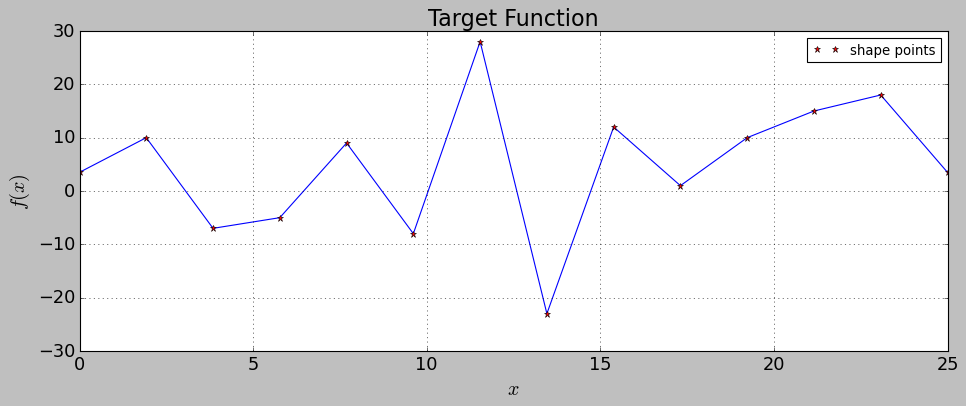

In [3]:
'''Generate the scaffolding of the manufactured solution'''

from engy_5310.toolkit import TargetFunction   
import numpy as np

shape_pts_y = [u_a_0,10,-7,-5,9,-8,28,-23,12,1,10,15,18,u_b_0]
shape_pts_x = [x for x in np.linspace(x_a, x_b, len(shape_pts_y))]
shape_pts = list(zip(shape_pts_x, shape_pts_y))

f = TargetFunction(shape_pts, type='linear')
      
f.plot(n_plot_pts=300, show_shape_pts=True, title='Target Function')

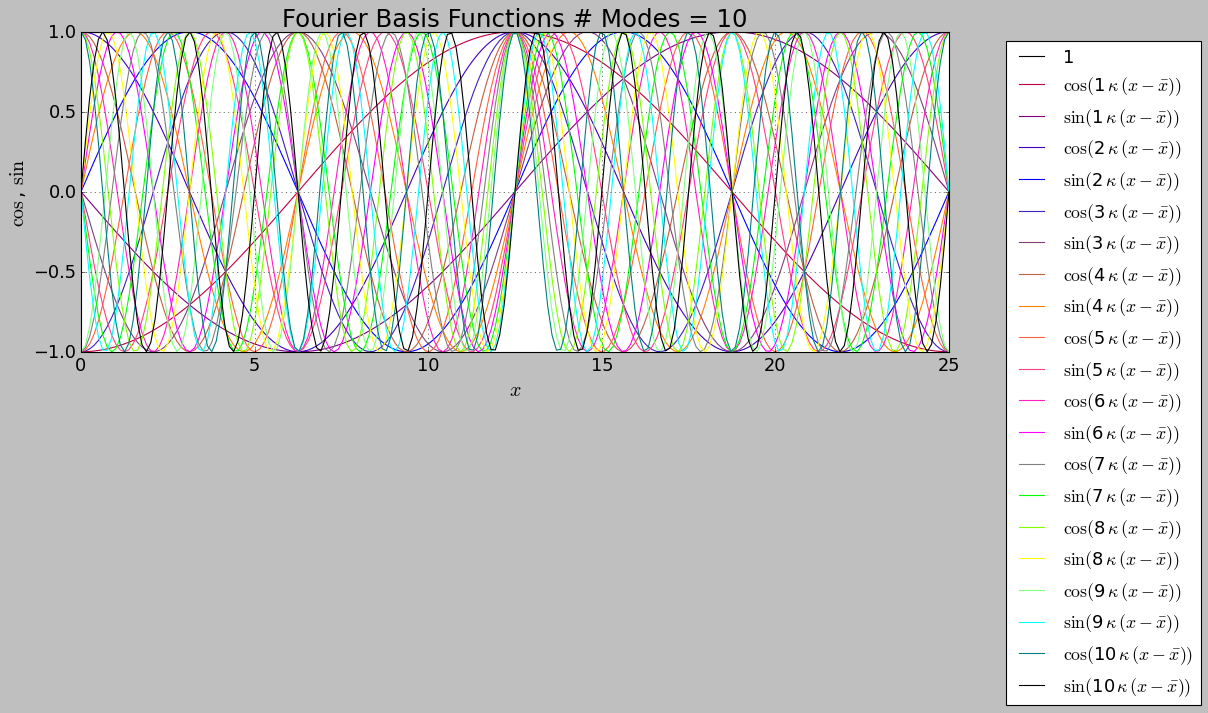

In [4]:
'''Build the basis functions list'''

import math

wavelength = x_b - x_a
kappa = 2*math.pi/wavelength

N = 10 # number of pairs of sine/cosine

try:    
    from engy_5310.toolkit import FourierBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

fb = FourierBasis(kappa, N, x_a, x_b)
fb.plot()

In [5]:
'''Build the Gram matrix'''

gram_mtrx = fb.gram_matrix(constrain_end_points=True)

#np.set_printoptions(precision=1, threshold=1000, edgeitems=20, linewidth=200)
#print(gram_mtrx)

if gram_mtrx.shape[0] > gram_mtrx.shape[1]:
    print('G is overdetermined.')
elif gram_mtrx.shape[0] < gram_mtrx.shape[1]:
    print('G is underdetermined.')  
else:
    print('G is determined.')

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(gram_mtrx) == min(gram_mtrx.shape):
    print('G is full rank.')
else:
    print('G is rank deficient.')

G is determined.
G is full rank.


In [6]:
'''Build load vector'''

b_vec = np.zeros(len(fb.basis_func_list), dtype=np.float64)

for i, phi_i in enumerate(fb.basis_func_list):
    (b_vec[i], _) = fb.inner_product(f, phi_i, epsabs=1e-3, epsrel=1.e-3, limit=1500) \
                  + f(x_a)*phi_i(x_a) + f(x_b)*phi_i(x_b)               

In [7]:
'''Compute optimal coefficient vector'''

beta_vec = np.linalg.solve(gram_mtrx, b_vec)

### [Manufactured Function](#toc)<a id="manufactured-function"></a>

In [8]:
'''Build the best approximant function'''

def u_manufactured(x):
    return fb.evaluation_matrix(x)@beta_vec

def u_prime_manufactured(x):
    return fb.evaluation_matrix(x, derivative=True)@beta_vec

def diff_flux_x_manufactured(x):
    return -diff_coeff*u_prime_manufactured(x)

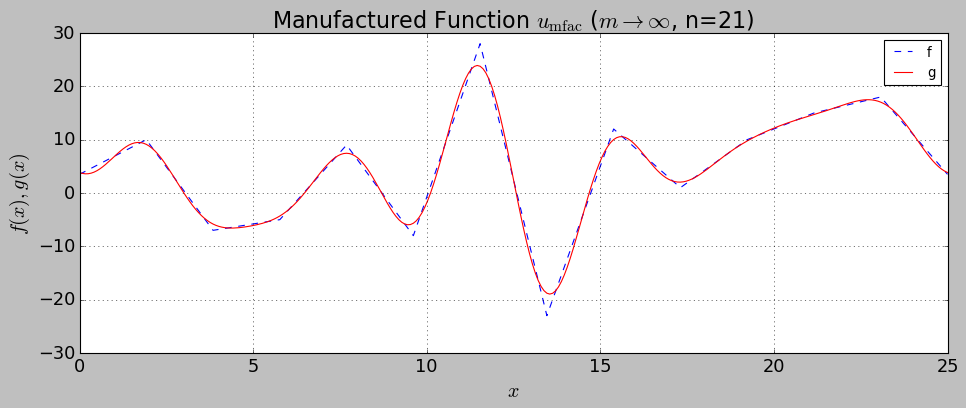

In [9]:
'''Plot comparison of '''

n_pts = 300
x_pts = np.linspace(x_a, x_b, n_pts)

u = u_manufactured(x_pts)

f.plot(g=(x_pts,u), n_plot_pts=n_pts, 
       title=r'Manufactured Function $u_\mathrm{mfac}$ ($m\rightarrow\infty$, n='+str(len(fb.basis_func_list))+')',
       f_line_style='dashed', g_line_style='continuous')

In [10]:
print('u_mfac(x_a) = ', u_manufactured(x_a), '; u_a_0 = ', u_a_0)
print('u_mfac(x_b) = ', u_manufactured(x_b), '; u_b_0 = ', u_b_0)

u_mfac(x_a) =  [3.8449365] ; u_a_0 =  3.5
u_mfac(x_b) =  [3.8449365] ; u_b_0 =  3.5


In [11]:
print("u'_mfac(x_a) = ", u_prime_manufactured(x_a))
print("u'_mfac(x_b) = ", u_prime_manufactured(x_b))

u'_mfac(x_a) =  [-2.60050322]
u'_mfac(x_b) =  [-2.60050322]


In [12]:
'''Update Boundary Condition Values'''

u_a = u_manufactured(x_a)
u_b = u_manufactured(x_b)

### [Manufactured Source](#toc)<a id="manufactured-source"></a>

In [13]:
'''Build the best approximant function'''

def u_prime2_manufactured(x):
    return fb.evaluation_matrix(x, derivative_2=True)@beta_vec

In [14]:
'''Build the best approximant function'''

def source_bias(x):
    return -diff_coeff * u_prime2_manufactured(x) - source_slope_value * u_manufactured(x)

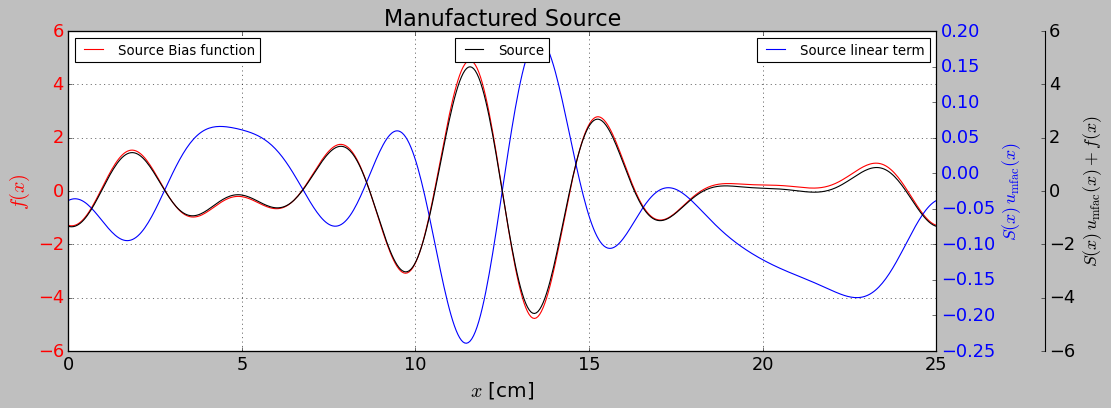

In [15]:
'''Source function'''

n_pts = 500
x = np.linspace(x_a, x_b, n_pts)
f_values = source_bias(x)
s_u_values = source_slope_value * u_manufactured(x)

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
(fig, ax1) = plt.subplots(1, figsize=(14, 5))

ax1.plot(x, f_values, 'r-', label='Source Bias function')
ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
ax1.set_ylabel(r'$f(x)$', fontsize=18, color='red')
ax1.tick_params(axis='y', labelcolor='red', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(x, s_u_values,'-', color='blue', label='Source linear term')
ax2.set_ylabel(r"$S(x)\, u_\mathrm{mfac}(x)$", fontsize=16, color='blue')
ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
ax2.legend(loc='upper right', fontsize=12)

ax3 = ax1.twinx()
ax3.plot(x, s_u_values+f_values,'-', color='black', label='Source')
ax3.set_ylabel(r"$S(x)\, u_\mathrm{mfac}(x) + f(x)$", fontsize=16, color='black')
ax3.tick_params(axis='y', labelcolor='black', labelsize=16)
ax3.legend(loc='upper center', fontsize=12)
ax3.spines["right"].set_position(("axes", 1.125))

plt.title(r'Manufactured Source', fontsize=20)
plt.show()

In [16]:
'''Source bias evaluated at the boundaries'''

np.set_printoptions(precision=5)
print('f(x_a) = ',source_bias(x_a), '   f(x_b) = ',source_bias(x_b))

f(x_a) =  [-1.28522]    f(x_b) =  [-1.28522]


## [Rayleigh-Ritz Method w/ Finite Element Basis Functions](#toc)<a id="rayleigh-ritz-fem"></a>

Find $u^*_N \in V_N(a,b)\subset V(a,b) = \bigl\{ u:[a,b]\subset\Reals\rightarrow\Reals  \bigr\}$ such that it minimizes the constrained Poisson energy norm:

\begin{equation*}
  \norm{u_0+w-u^*_N}^2_{\Ecal} = \min\limits_{u_N\, \in\, V_N} \norm{u_0+w-u_N}^2_{\Ecal},
\end{equation*}

where 
$V_N(a,b) := \bigl\{ u_N = \sum\limits_{i=1}^N\,c_i\,\phi_i \mid u_N(a) = u_N(b) = 0, (u'_N,u'_N) < \infty \bigr\}$, $\{\phi_i\mid i=1\ldots,N\}$ is a basis of $V_N(a,b)$, and any $w \in V$ with $w(a) = u_a$, $w(b) = u_b$ is called the *lift* function. $u_0 \in V(a,b)$ is the solution of the homogeneous problem.

The optimum coefficients $\cvec^* := \{c_i\mid i=1,\ldots,N\}$ solve

\begin{equation*}
 \overset{(N\times N)}{\Amtrx}\,\overset{(N\times 1)}{\cvec^*} = \overset{(N\times 1)}\bvec ,
\end{equation*}

where:
  + $A_{i,j} = (D\,\phi'_i,\phi'_j) - (S\,\phi_i,\phi_j)$
  + $b_i = (f,\phi_i) - (D\,w',\phi'_i) + (S\,w,\phi_i)$
  
This formulation uses basis functions that satisfy homogeneous boundary conditions, however the linear algebraic problem for the optimum coefficients accounts for the inhomogeneous boundary condition data through the lift function $w$.

### [Lift Function](#toc)<a id="lift-function"></a>
Since $w\in V(a,b)$, construct as follows $w = \sum\limits_{i=1}^N\,\alpha_i\,\phi_i$ such that $w(a) = u_a$ and $w(b) = u_b$.

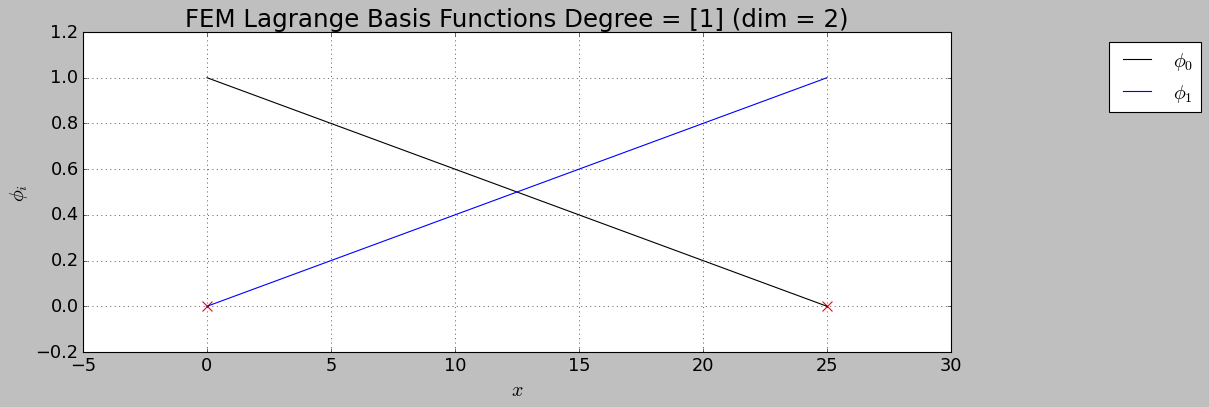

In [17]:
'''Build the lift basis functions'''

degree = 1

try:    
    from engy_5310.toolkit import LagrangeFEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

lift_basis = LagrangeFEMBasis(degree=degree, n_elem=1, x_partition=[x_a, x_b])
lift_basis.plot(n_plot_pts=300)

In [18]:
'''Build the coefficients of the lift function'''

alpha_vec = np.zeros(len(lift_basis.basis_func_list))
alpha_vec[0] = u_a
if degree == 2:
   alpha_vec[-2] = u_b
else:
   alpha_vec[-1] = u_b

In [19]:
'''Build the lift function'''

def w_lift(x):
    return lift_basis.evaluation_matrix(x)@alpha_vec

In [20]:
'''Build the lift function derivative'''

def w_lift_prime(x):
    return lift_basis.evaluation_matrix(x, derivative=True)@alpha_vec

In [21]:
'''Test boundary values'''

print('w(a) = ',w_lift(x_a), ' w(b) = ', w_lift(x_b))

w(a) =  [3.84494]  w(b) =  [3.84494]


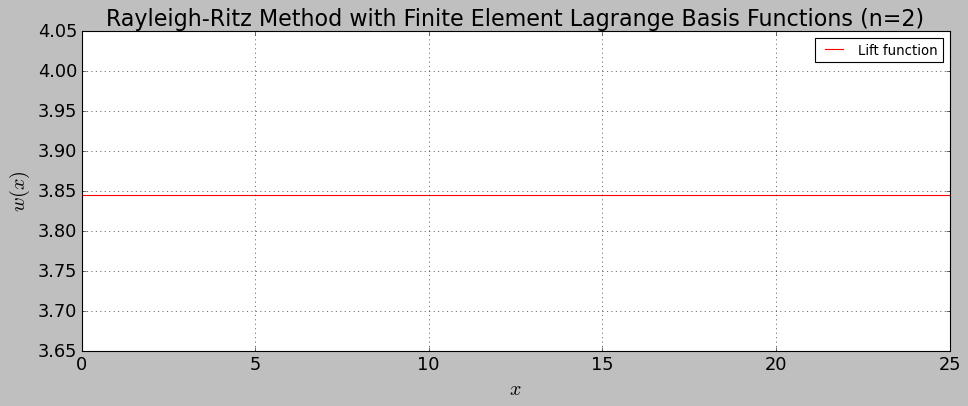

In [22]:
'''Rayleigh Ritz Method with Lagrange Basis Functions'''

n_pts = 500
x = np.linspace(x_a, x_b, n_pts)
u_values = w_lift(x)

import matplotlib.pyplot as plt
#%matplotlib inline
#plt.style.use('dark_background')
plt.figure(1, figsize=(14, 5))

plt.plot(x, u_values, 'r-', label='Lift function')

plt.title(r'Rayleigh-Ritz Method with Finite Element Lagrange Basis Functions (n='+str(len(lift_basis.basis_func_list))+')', fontsize=20)
plt.ylabel(r'$w(x)$', fontsize=18)
plt.xlabel(r'$x$', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.grid(True)
plt.show()

### [Finite Element Lagrange Basis Functions](#toc)<a id="fem-lagrange-basis-inhomogeneous"></a>

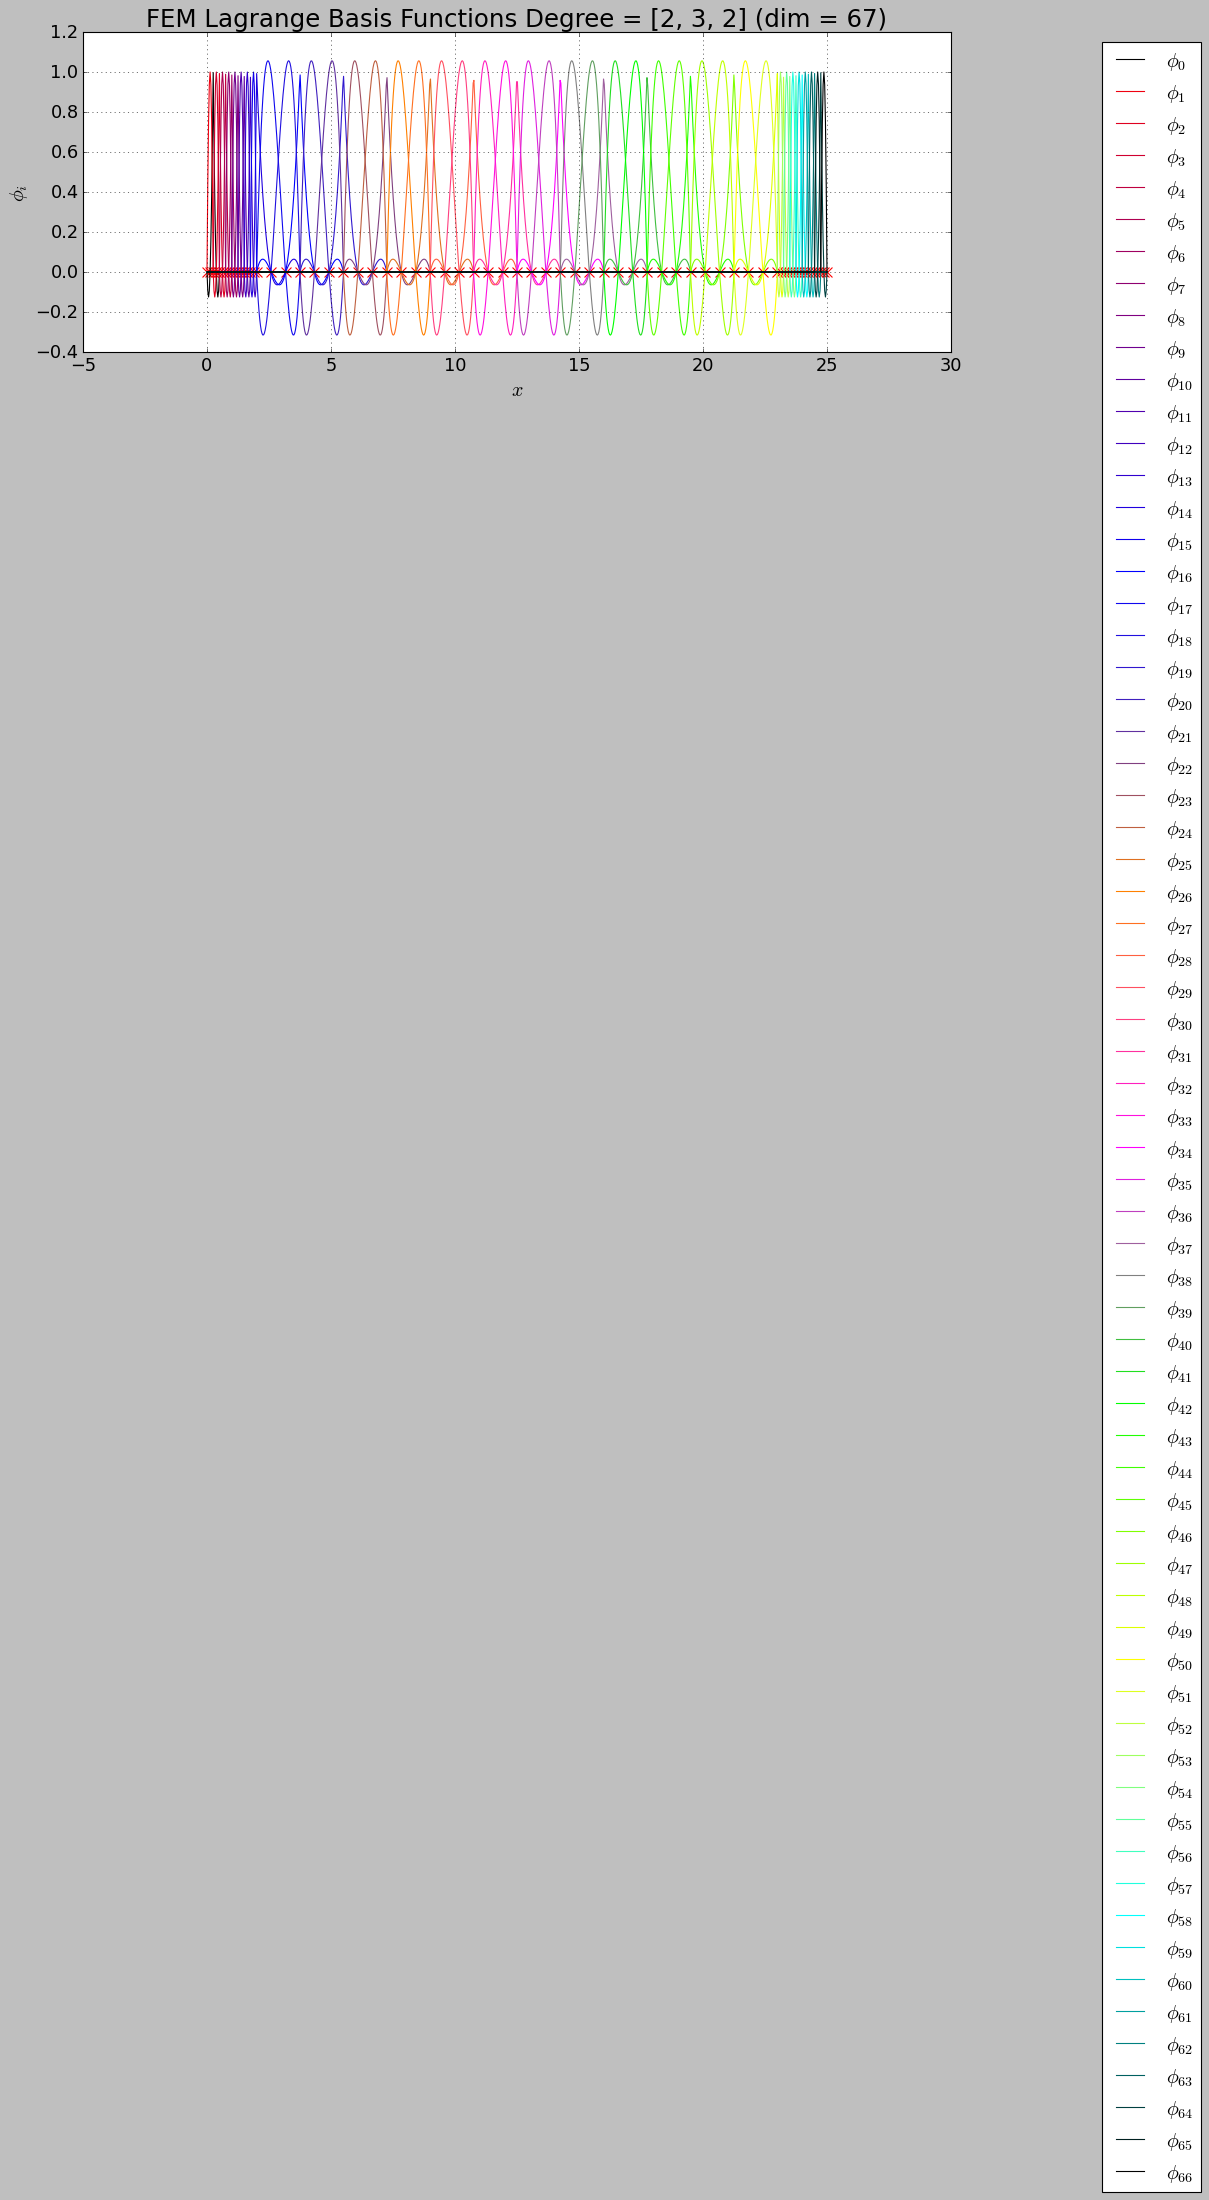

In [24]:
'''Build the basis functions'''

degree = 3
n_elem=[8,12,8]

degree = [2,3,2]
#n_elem = [3,8,3]

try:    
    from engy_5310.toolkit import LagrangeFEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
femlb = LagrangeFEMBasis(degree=degree, n_elem=n_elem, x_partition=[x_a, x_a+2, x_b-2, x_b], bc_x_min='dirichlet', bc_x_max='dirichlet')
femlb.plot(n_plot_pts=800)

In [25]:
'''Mesh artifact'''

for (p_id, elem_gnode_ids) in enumerate(femlb.local_to_global_node_id_map):
    print('Partition %i'%p_id, ' Degree %i'%(femlb.degree_partition[p_id]))
    for (e_id, gnode_ids) in enumerate(elem_gnode_ids):
        printout = '\t element #%i:'%e_id
        for (lnode_id, gnode_id) in enumerate(gnode_ids):
            printout += ' x_%i = %+5.2e'%(gnode_id, femlb.patches[p_id][e_id][lnode_id])
        print(printout)

Partition 0  Degree 2
	 element #0: x_-1 = +0.00e+00 x_2 = +2.50e-01 x_1 = +1.25e-01
	 element #1: x_2 = +2.50e-01 x_4 = +5.00e-01 x_3 = +3.75e-01
	 element #2: x_4 = +5.00e-01 x_6 = +7.50e-01 x_5 = +6.25e-01
	 element #3: x_6 = +7.50e-01 x_8 = +1.00e+00 x_7 = +8.75e-01
	 element #4: x_8 = +1.00e+00 x_10 = +1.25e+00 x_9 = +1.12e+00
	 element #5: x_10 = +1.25e+00 x_12 = +1.50e+00 x_11 = +1.38e+00
	 element #6: x_12 = +1.50e+00 x_14 = +1.75e+00 x_13 = +1.62e+00
	 element #7: x_14 = +1.75e+00 x_16 = +2.00e+00 x_15 = +1.88e+00
Partition 1  Degree 3
	 element #0: x_16 = +2.00e+00 x_19 = +3.75e+00 x_17 = +2.58e+00 x_18 = +3.17e+00
	 element #1: x_19 = +3.75e+00 x_22 = +5.50e+00 x_20 = +4.33e+00 x_21 = +4.92e+00
	 element #2: x_22 = +5.50e+00 x_25 = +7.25e+00 x_23 = +6.08e+00 x_24 = +6.67e+00
	 element #3: x_25 = +7.25e+00 x_28 = +9.00e+00 x_26 = +7.83e+00 x_27 = +8.42e+00
	 element #4: x_28 = +9.00e+00 x_31 = +1.08e+01 x_29 = +9.58e+00 x_30 = +1.02e+01
	 element #5: x_31 = +1.08e+01 x_34 = +

  + $A_{i,j} = (D\,\phi'_i,\phi'_j) - (S\,\phi_i,\phi_j)$

In [26]:
'''Deprecated: Build the matrix of coefficients of the linear system'''

import numpy as np

def get_a_mtrx(femlb):
    n = len(femlb.basis_func_list)
    a_mtrx = np.zeros((n, n), dtype=np.float64)
  
    for i,phi_prime_i in enumerate(femlb.basis_func_prime_list):
        for j,phi_prime_j in enumerate(femlb.basis_func_prime_list):
            (a_ij, _) = femlb.inner_product(phi_prime_j, phi_prime_i)
            a_mtrx[i,j] = a_ij * diff_coeff
        
    for i,phi_i in enumerate(femlb.basis_func_list):
        for j,phi_j in enumerate(femlb.basis_func_list):
            (a_ij, _) = femlb.inner_product(phi_j, phi_i)
            a_mtrx[i,j] -= a_ij * source_slope_value
            
    return a_mtrx

In [ ]:
'''Deprecated: Form matrix (this is slow)'''

a_mtrx = get_a_mtrx(femlb)

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_mtrx) == min(a_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

In [ ]:
np.set_printoptions(precision=2, threshold=200, edgeitems=10, linewidth=170)
print(a_mtrx)
a_mtrx.shape

try:    
    from engy_5310.toolkit import plot_matrix   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
plot_matrix(a_mtrx)

  + $A_{i,j} = (D\,\phi'_i,\phi'_j) - (S\,\phi_i,\phi_j)$

In [27]:
'''Assemble A matrix element-by-element'''
from scipy.integrate import quad

def assemble_a_matrix(fembf):
    
    n_dof = fembf.n_dof # total number of degrees of freedom
    a_mtrx = np.zeros((n_dof,n_dof), dtype=np.float64)

    for (p_id, degree) in enumerate(fembf.degree_partition):  
        # number of local nodes
        n = len(femlb.parent_basis_func_list[degree])
    
        local_a_diff_mtrx = np.zeros((n, n), dtype=np.float64)
        local_a_source_mtrx = np.zeros((n, n), dtype=np.float64)
    
        for I in range(n):
            parent_basis_func_prime_I = femlb.parent_basis_func_prime_list[degree][I]
            parent_basis_func_I = femlb.parent_basis_func_list[degree][I]
            for J in range(n):
                integrand = lambda zeta: parent_basis_func_prime_I(zeta) * \
                                         diff_coeff * femlb.parent_basis_func_prime_list[degree][J](zeta)                                                                  
                (local_a_diff_mtrx[I,J], _) = quad(integrand, -1, 1)
                integrand = lambda zeta: - parent_basis_func_I(zeta) * \
                                         source_slope_value * femlb.parent_basis_func_list[degree][J](zeta)                                                                      
                (local_a_source_mtrx[I,J], _) = quad(integrand, -1, 1)
            
        for (e, dof_ids) in enumerate(femlb.dof_ids[p_id]):
            patch_nodes_x = femlb.patches[p_id][e]
            h_e = patch_nodes_x[1] - patch_nodes_x[0]
            parent_mapping_jacobian = femlb.parent_mapping_prime(h_e)
            for (I, i) in enumerate(dof_ids):
                if i < 0: continue
                for (J, j) in enumerate(dof_ids):
                    if j < 0: continue
                    a_mtrx[i,j] += local_a_diff_mtrx[I,J] / parent_mapping_jacobian + \
                                   local_a_source_mtrx[I,J] * parent_mapping_jacobian
   
    return a_mtrx

In [28]:
'''Assemble matrix element-by-element'''

a_mtrx = assemble_a_matrix(femlb)

try:    
    from engy_5310.toolkit import matrix_rank
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
if matrix_rank(a_mtrx) == min(a_mtrx.shape):
    print('A is full rank.')
else:
    print('A is rank deficient.')

A is full rank.


[[ 1.86733 -1.0665   0.13325 ...  0.       0.       0.     ]
 [-1.0665   2.13467  0.      ...  0.       0.       0.     ]
 [ 0.13325  0.       1.86733 ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ...  1.86733 -1.0665  -1.0665 ]
 [ 0.       0.       0.      ... -1.0665   2.13467  0.     ]
 [ 0.       0.       0.      ... -1.0665   0.       2.13467]]
matrix shape = (67, 67)


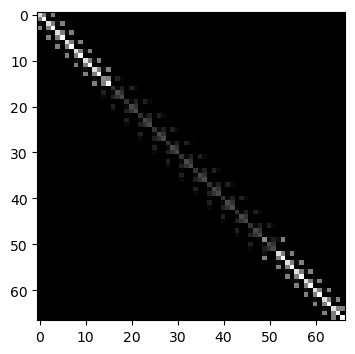

In [29]:
print(a_mtrx)
a_mtrx.shape
try:    
    from engy_5310.toolkit import plot_matrix   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
plot_matrix(a_mtrx)

  + $b_i = (f,\phi_i) - (D\,w',\phi'_i) + (S\,w,\phi_i)$

In [ ]:
'''Deprecated: form load vector (this is slow)'''

def get_b_vec(femlb):
    
    b_vec = np.zeros(len(femlb.basis_func_list), dtype=np.float64)
    for i, phi_i in enumerate(femlb.basis_func_list):
        (b_vec[i], _) = femlb.inner_product(source_bias, phi_i)
        d_x_w_lift_prime = lambda x: diff_coeff * w_lift_prime(x)
        (term1, _) = femlb.inner_product(d_x_w_lift_prime, femlb.basis_func_prime_list[i])
        b_vec[i] -= term1
        s_x_w = lambda x: source_slope_value * w_lift(x)
        (term2, _) = femlb.inner_product(s_x_w, phi_i)
        b_vec[i] +=  term2
        
    return b_vec

In [ ]:
#b_vec = get_b_vec(femlb)

  + $b_i = (f,\phi_i) - (D\,w',\phi'_i) + (S\,w,\phi_i)$

In [30]:
'''Assemble load vector element-by-element'''
from scipy.integrate import quad

def assemble_b_vector(fembf):
    
    n_dof = fembf.n_dof # total number of degrees of freedom
    b_vec = np.zeros(n_dof, dtype=np.float64)

    for (p_id, degree) in enumerate(fembf.degree_partition):  
        # number of local nodes
        n = len(femlb.parent_basis_func_list[degree])
    
        local_b_bias_vec = np.zeros(n, dtype=np.float64)
        local_b_diff_vec = np.zeros(n, dtype=np.float64)
        local_b_source_vec = np.zeros(n, dtype=np.float64)
            
        for (e, dof_ids) in enumerate(femlb.dof_ids[p_id]):
            patch_nodes_x = femlb.patches[p_id][e]
            h_e = patch_nodes_x[1] - patch_nodes_x[0]
            x_e_bar = (patch_nodes_x[0] + patch_nodes_x[1])/2.0
            parent_mapping_jacobian = femlb.parent_mapping_prime(h_e)
            
            for I in range(n):
                parent_basis_func_I = femlb.parent_basis_func_list[degree][I]
                parent_basis_func_prime_I = femlb.parent_basis_func_prime_list[degree][I]
                
                source_bias_parent = lambda zeta, x_e_bar=x_e_bar, h_e=h_e: \
                                     source_bias(femlb.parent_mapping(zeta, x_e_bar, h_e))
          
                integrand = lambda zeta: \
                            source_bias_parent(zeta) * parent_basis_func_I(zeta)   
            
                (local_b_bias_vec[I], _) = quad(integrand, -1, 1)
                
                w_lift_prime_parent = lambda zeta, x_e_bar=x_e_bar, h_e=h_e: \
                                      w_lift_prime(femlb.parent_mapping(zeta, x_e_bar, h_e))
        
                integrand = lambda zeta: \
                            - diff_coeff * w_lift_prime_parent(zeta) * parent_basis_func_prime_I(zeta)
            
                (local_b_diff_vec[I], _) = quad(integrand, -1, 1)
                
                w_lift_parent = lambda zeta, x_e_bar=x_e_bar, h_e=h_e: \
                                w_lift(femlb.parent_mapping(zeta, x_e_bar, h_e))
                
                integrand = lambda zeta: \
                            source_slope_value * w_lift_parent(zeta) * parent_basis_func_I(zeta)
                
                (local_b_source_vec[I], _) = quad(integrand, -1, 1)       
            
            for (I, i) in enumerate(dof_ids):
                if i < 0: continue
                b_vec[i] += local_b_bias_vec[I] * parent_mapping_jacobian + \
                               local_b_diff_vec[I] / parent_mapping_jacobian + \
                               local_b_source_vec[I] * parent_mapping_jacobian
   
    return b_vec

In [31]:
b_vec = assemble_b_vector(femlb)

In [32]:
'''Compute optimal coefficient vector'''

c_star_vec = np.linalg.solve(a_mtrx, b_vec)

#### [FEM Solution](#toc)<a id="results-lagrange"></a>

In [33]:
'''Build the best approximation function in V_N'''

def u_star(x, femlb, c_star_vec):
    u_0 = femlb.evaluation_matrix(x)@c_star_vec
    w = lift_basis.evaluation_matrix(x)@alpha_vec
    return u_0 + w

In [34]:
'''Build the best approximation function derivative in V_N'''

def u_prime_star(x, femlb, c_star_vec):
    u_0 = femlb.evaluation_matrix(x, derivative=True)@c_star_vec
    w = lift_basis.evaluation_matrix(x, derivative=True)@alpha_vec
    return u_0 + w

In [35]:
def diff_flux_x_star(x, femlb, c_star_vec):
    return -diff_coeff*u_prime_star(x, femlb, c_star_vec)

In [36]:
'''Rayleigh Ritz Method with FEM Lagrange Basis Functions'''

def plot_solution(bf_type='lagrange', cases=[(femlb, c_star_vec)], plot_flux=True):
    import matplotlib.pyplot as plt
    #%matplotlib inline
    #plt.style.use('dark_background')
    (fig, ax1) = plt.subplots(1, figsize=(14, 5))
    ax2 = ax1.twinx()
        
    n_pts = 500
    
    x = np.linspace(x_a, x_b, n_pts)
    ax1.plot(x, u_manufactured(x), 'k--', label=r'$u$: exact')
    if plot_flux:
        ax2.plot(x, diff_flux_x_manufactured(x), 'k-.', label=r"$-k\,u'$: exact")
    
    for (case, (femlb, c_star_vec)) in enumerate(cases):
        u_values = u_star(x, femlb, c_star_vec)
        diff_flux_x_values = diff_flux_x_star(x, femlb, c_star_vec)
        
        ax1.plot(x, u_values, 'r-', label=r'$u_{N_0}$: N = '+str(len(femlb.basis_func_list)))
        ax1.set_xlabel(r'$x$ [cm]', fontsize=18)
        ax1.set_ylabel(r'$u_{N}$ [g/cc]', color='red', fontsize=18)
        ax1.tick_params(axis='y', labelcolor='red', labelsize=16)
        ax1.tick_params(axis='x', labelsize=16)
        ax1.legend(loc='upper left', fontsize=12)
        ax1.grid(True)

        if plot_flux:
            ax2.plot(x, diff_flux_x_values,'-', color='blue', label=r'$q_x$: N = '+str(len(femlb.basis_func_list)))
            ax2.set_ylabel(r"$q_x$ [g/cm$^2$-s]", fontsize=16, color='blue')
            ax2.tick_params(axis='y', labelcolor='blue', labelsize=16)
            ax2.legend(loc='upper right', fontsize=12)

    if bf_type == 'lagrange':
        plt.title(r'Rayleigh-Ritz Method with FE Lagrange Basis Functions (degree='+str(degree)+' dim='+str(len(femlb.basis_func_list))+')', fontsize=20)
    else:
        plt.title(r'Rayleigh-Ritz Method with FE Hermite Basis Functions (degree='+str(degree)+' dim='+str(len(femlb.basis_func_list))+')', fontsize=20)  
    plt.show()

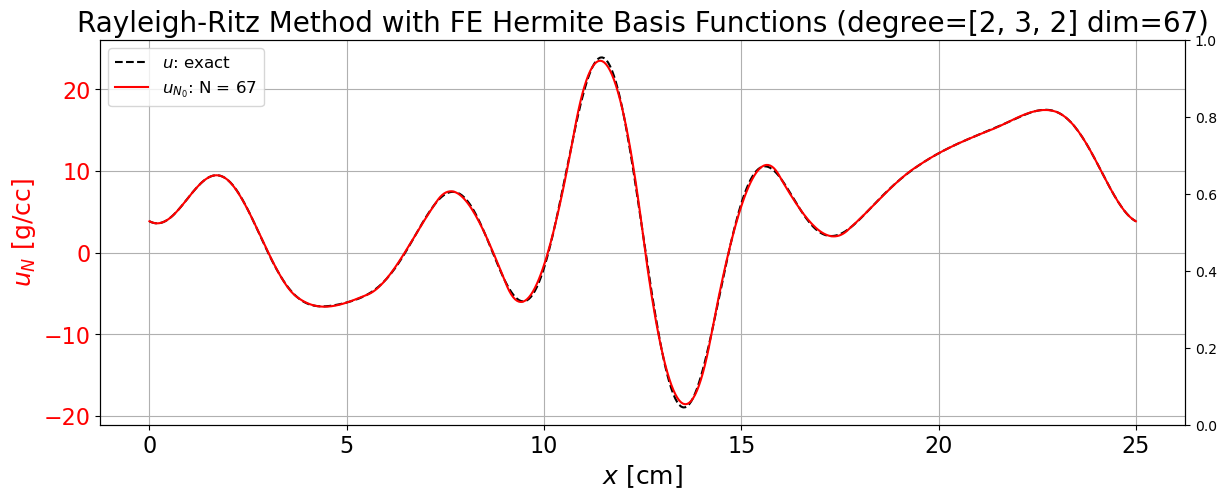

In [37]:
plot_solution([(femlb, c_star_vec)], plot_flux=False)

In [38]:
'''L2 norm relative error'''

from scipy.integrate import quad
import math

u_mfac2_integral, error = quad(lambda x: u_manufactured(x)**2, x_a, x_b, limit=1000)
print('||u_mfac||_L2 =', math.sqrt(u_mfac2_integral))
#print('quadrature error =', error)

print('')
integrand = lambda x, bf=femlb, c=c_star_vec: (u_manufactured(x)-u_star(x, bf, c))**2
(u_mfac_minus_u_star_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)
print('||u_mfac-u||_L2 =', math.sqrt(u_mfac_minus_u_star_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%%] = %3.3e'%(math.sqrt(u_mfac_minus_u_star_2_integral)/math.sqrt(u_mfac2_integral)*100))

||u_mfac||_L2 = 51.19407408360283

||u_mfac-u||_L2 = 0.8505666548465801

Relative error [%] = 1.661e+00


In [39]:
'''Nodal errors 2-norm'''

error_2norm = np.linalg.norm(u_manufactured(femlb.gnodes_x) - u_star(femlb.gnodes_x, femlb, c_star_vec))
u_mfac_2norm = np.linalg.norm(u_manufactured(femlb.gnodes_x))

print('||u-u_mfac||_2/||u_mfac||_2 [%%] = %3.3e'%(error_2norm/u_mfac_2norm*100))

||u-u_mfac||_2/||u_mfac||_2 [%] = 6.550e-01


In [40]:
'''Rayleigh-Ritz solution evaluated at the boundaries'''

np.set_printoptions(precision=5)
print('u_N(a) = ',u_star(x_a, femlb, c_star_vec), '  u_N(b) = ',u_star(x_b, femlb, c_star_vec))

u_N(a) =  [3.84494]   u_N(b) =  [3.84494]


In [41]:
'''L2 norm relative error'''

from scipy.integrate import quad
import math

u_prime_mfac2_integral, error = quad(lambda x: u_prime_manufactured(x)**2, x_a, x_b, limit=1000)
print("||u'_mfac||_L2 =", math.sqrt(u_prime_mfac2_integral))
#print('quadrature error =', error)

print('')
integrand = lambda x, bf=femlb, c=c_star_vec: (u_prime_manufactured(x)-u_prime_star(x, bf, c))**2
(u_prime_mfac_minus_u_prime_star_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)
print("||u'_mfac-u||_L2 =", math.sqrt(u_prime_mfac_minus_u_prime_star_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%%] = %3.3e'%(math.sqrt(u_prime_mfac_minus_u_prime_star_2_integral)/math.sqrt(u_prime_mfac2_integral)*100))

||u'_mfac||_L2 = 52.5706949071637

||u'_mfac-u||_L2 = 12.690887418025621

Relative error [%] = 2.414e+01


<ipython-input-41-16096e09f710>:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  (u_prime_mfac_minus_u_prime_star_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)


In [42]:
'''Rayleigh-Ritz solution evaluated at the boundaries'''

np.set_printoptions(precision=5)
print("u'_N(a) = ", u_prime_star(x_a, femlb, c_star_vec), "  u'_N(b) = ", u_prime_star(x_b, femlb, c_star_vec))
print("u'_mfac(a) = ", u_prime_manufactured(x_a), "  u'_mfac(b) = ", u_prime_manufactured(x_b))

u'_N(a) =  [-0.32489]   u'_N(b) =  [-0.33003]
u'_mfac(a) =  [-2.6005]   u'_mfac(b) =  [-2.6005]


### [Finite Element Hermite Basis Functions](#toc)<a id="fem-hermite-basis-inhomogeneous"></a>

In [ ]:
#'''Hermite finite element basis functions'''

try:    
    from engy_5310.toolkit import HermiteFEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

degree = 3

femhb = HermiteFEMBasis(degree=degree, n_elem=[6,6], x_partition=[x_a, 12, x_b], bc_x_min='dirichlet', bc_x_max='dirichlet')
a_mtrx = get_a_mtrx(femhb)
b_vec = get_b_vec(femhb)
c_star_vec = np.linalg.solve(a_mtrx, b_vec)

#### [FEM Solution](#toc)<a id="results-hermite"></a>

In [ ]:
plot_solution('hermite', [(femhb, c_star_vec)])

In [ ]:
'''L2 norm relative error'''

from scipy.integrate import quad
import math

u_mfac2_integral, error = quad(lambda x: u_manufactured(x)**2, x_a, x_b, limit=1000)
print('||u_mfac||_L2 =', math.sqrt(u_mfac2_integral))
#print('quadrature error =', error)

print('')
integrand = lambda x, bf=femhb, c=c_star_vec: (u_manufactured(x)-u_star(x, bf, c))**2
(u_mfac_minus_u_star_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)
print('||u_mfac-u||_L2 =', math.sqrt(u_mfac_minus_u_star_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%%] = %3.3e'%(math.sqrt(u_mfac_minus_u_star_2_integral)/math.sqrt(u_mfac2_integral)*100))

In [ ]:
'''L2 norm relative error'''

from scipy.integrate import quad
import math

u_prime_mfac2_integral, error = quad(lambda x: u_prime_manufactured(x)**2, x_a, x_b, limit=1000)
print("||u'_mfac||_L2 =", math.sqrt(u_prime_mfac2_integral))
#print('quadrature error =', error)

print('')
integrand = lambda x, bf=femhb, c=c_star_vec: (u_prime_manufactured(x)-u_prime_star(x, bf, c))**2
(u_prime_mfac_minus_u_prime_star_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)
print("||u'_mfac-u||_L2 =", math.sqrt(u_prime_mfac_minus_u_prime_star_2_integral))
#print('quadrature error =', error)

print('')
print('Relative error [%%] = %3.3e'%(math.sqrt(u_prime_mfac_minus_u_prime_star_2_integral)/math.sqrt(u_prime_mfac2_integral)*100))

### [Mesh Convergence](#toc)<a id="mesh-convergence"></a>

In [ ]:
'''Mesh convergence test'''
import math

def mesh_convergence(type, degree, n_elem, x_partition, fembf, c_star_vec):
    assert type in ['lagrange', 'hermite']
    
    fembf_0 = fembf
    c_star_vec_0 = np.copy(c_star_vec)
    u_0 = u_star(fembf_0.gnodes_x, fembf_0, c_star_vec_0)

    cases = [(fembf_0, c_star_vec_0)] # mesh refinement cases
    degree = degree
    
    h = list()
    for elem_patches in femlb.patches:
        for patch in elem_patches:
            h.append(patch[1]-patch[0])
    h = np.array(h).mean()

    integrand = lambda x, bf=fembf, c=c_star_vec: (u_manufactured(x) - u_star(x, bf, c))**2
    (u_exact_minus_u_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)
    error_0 = math.sqrt(u_exact_minus_u_2_integral)
    
    power_law_data = list()

    for i in range(1,15):
        n_elem = [j+2 for j in n_elem]
        print(n_elem)
        
        if type == 'lagrange':
            fembf = LagrangeFEMBasis(degree=degree, n_elem=n_elem, x_partition=x_partition, bc_x_min='dirichlet', bc_x_max='dirichlet')
        if type == 'hermite':
            fembf = HermiteFEMBasis(degree=degree, n_elem=n_elem, x_partition=x_partition, bc_x_min='dirichlet', bc_x_max='dirichlet')
        
        a_mtrx = assemble_a_matrix(fembf)
        b_vec = assemble_b_vector(fembf)
        c_star_vec = np.linalg.solve(a_mtrx, b_vec)

        h = list()
        for elem_patches in femlb.patches:
            for patch in elem_patches:
                h.append(patch[1]-patch[0])
        h = np.array(h).mean()
            
        integrand = lambda x, bf=fembf, c=c_star_vec: (u_manufactured(x) - u_star(x, bf, c))**2
        (u_exact_minus_u_2_integral, _) = quad(integrand, x_a, x_b, limit=1000)
        error = math.sqrt(u_exact_minus_u_2_integral)
        
        (u_mfac2_integral, _) = quad(u_manufactured, x_a, x_b, limit=1000)
        relative_error = math.sqrt(error)/math.sqrt(u_mfac2_integral)*100
        
        if h <= (x_b-x_a)/20: # discard coarse meshes case
            power_law_data.append((math.log(h), math.log(error)))
    
        p = (math.log(error) - math.log(error_0))/(math.log(h)-math.log(h_0))
        print('# elem = %i; relative ||u_mfac - u_%i||_2 [%%] = %3.3e; h [cm] = %3.2f; p [] = %3.2f'%(sum(n_elem),i,relative_error,h,p))
        
        cases.append((fembf, c_star_vec))
        
        error_0 = error
        h_0 = h
        if relative_error < 1:
            break
    print('done.')
    return (cases, power_law_data)

#### [Lagrange Basis Functions](#toc)<a id="mesh-convergence-lagrange"></a>

In [ ]:
'''Build the basis functions'''

degree = 2
n_elem = [2]
x_partition = [x_a, x_b]

try:    
    from engy_5310.toolkit import LagrangeFEMBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'
    
femlb = LagrangeFEMBasis(degree=degree, n_elem=n_elem, x_partition=x_partition, bc_x_min='dirichlet', bc_x_max='dirichlet')
femlb.plot(n_plot_pts=800)

In [ ]:
a_mtrx = assemble_a_matrix(femlb)
b_vec = assemble_b_vector(femlb)
c_star_vec = np.linalg.solve(a_mtrx, b_vec)

In [ ]:
(cases, power_law_data) = mesh_convergence('lagrange', degree, n_elem, x_partition, femlb, c_star_vec)
plot_solution('lagrange', cases)
plot_solution('lagrange',[cases[-1]])

In [ ]:
f = TargetFunction(list(reversed(power_law_data)), type='stepwise')
#f.plot(show_shape_pts=True)

In [ ]:
try:    
    from engy_5310.toolkit import LegendreBasis  
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

x_tilde_vec = np.array([x[0] for x in reversed(power_law_data)])
    
lb = LegendreBasis(degree=1, x_min=x_tilde_vec[0], x_max=x_tilde_vec[-1])

a_tilde_mtrx = lb.evaluation_matrix(x_tilde_vec)

f_tilde_vec = np.array([x[1] for x in reversed(power_law_data)])

c_star_vec = np.linalg.solve(a_tilde_mtrx.transpose()@a_tilde_mtrx, a_tilde_mtrx.transpose()@f_tilde_vec)

def g_best_vec_func(x_pts):
    return lb.evaluation_matrix(x_pts)@c_star_vec

'''Plot comparison of f and g_best_vec'''

n_pts = 300
x_pts = np.linspace(x_tilde_vec[0], x_tilde_vec[-1], n_pts)

g_best_vec_2 = g_best_vec_func(x_pts)

f.plot(g=(x_pts,g_best_vec_2), n_plot_pts=n_pts, g_line_style='plain', show_shape_pts=True, f_line_style='dashed', 
       title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, n='+str(len(lb.basis_func_list))+')',
      y_label=r'$\ln$ Error', x_label=r'$\ln h$')

In [ ]:
print('Power exponent of error estimate = %2.3f'%c_star_vec[1])

In [ ]:
power_law_data